# Filter Signal with Added Discrete Spikes
This Notebook is to see if discrete spike events will produce detectable cycles.

Most important aspects:
- Say data is at minute level, with a discrete spike at some multiday period.
- Average timeseries to N-day 
- Will the data show a cyclical pattern?

In [26]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import pywt
from numpy.fft import rfft, rfftfreq
from scipy.signal import butter, sosfilt

In [27]:
# Scaling factor - Days -> Minutes (mins/days) - For consistency, we will use have precision in minutes, but units are in days
minsday = 24*60

In [ ]:
# Adjust parameters in this cell - No need to adjust anything else in rest of notebook

# Define the duration of the simulation
duration = 400 * minsday # In units of minutes - N days 
# Noise level
sigma = 5 # 5
# Base heart / signal rate
base = 60 # 60
# Moving average window
window = 1 * minsday # In units of minutes - N days

# Magnitude of discrete spike
spike_mag = 80
# Period between discrete spikes
spike_period = 4.5 * minsday # In units of minutes - N days
# Discrete spike width
spike_width = 20 # In units of minutes - N mins
# Method for generating discrete spikes
spike_method = 'stochastic_periodic' # 'periodic', 'stochastic_periodic', 'stochastic_exponential'

# Band-pass filter?
bandpass = False

# Normalisation for FT
normalisation = None # ortho, forward, backward, None

# Set random seed
np.random.seed(0)

# Simulation and Analysis

In [29]:
# Check if spike_method is valid since it's easy to make a typo
spike_method_options = ['periodic', 'stochastic_periodic', 'stochastic_exponential']
if spike_method not in spike_method_options:
    raise ValueError(f"Invalid spike_method: {spike_method}. Must be one of {spike_method_options}")

In [30]:
# Helper functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

In [ ]:
# Draw the heart rate / signal data from a normal distribution
data = np.random.normal(base, sigma, duration)

# Time vector
time = np.arange(0, duration) / minsday

# Sampling period
sampling_period = np.diff(time).mean()

# Apply bandpass filter if requested
if bandpass:
    data = butter_bandpass_filter(data, 1/spike_period*minsday*2/3, 1/spike_period*minsday*4/3, fs=1/sampling_period, order=2) # From 2021 paper, +-33% of the cycle frequency

# Take a N-day MA
data_MA = np.convolve(data, np.ones(window)/window, mode='valid')

# Take moving average with non-overlapping windows
data_MA_non_overlapping = np.mean(data[:len(data) // window * window].reshape(-1, window), axis=1)
time_non_overlapping = time[:len(time) // window * window:window]

In [32]:
# Add the discrete spikes
data_spikes = data.copy()

# Generate Spike Labels 

# Periodic Spikes - at every spike period, there is a chance of a spike
spike_index = []
for i in range(0, duration, int(spike_period)):
    # Periodic version - Make it have a spike at every spike period
    if spike_method == 'periodic':
        data_spikes[i-spike_width//2:i+spike_width//2] = spike_mag
        spike_index.append(i)

    # Stochastic version - Make it have a random chance of occuring
    elif spike_method == 'stochastic_periodic':
        if np.random.randint(0,2) == 1:
            data_spikes[i-spike_width//2:i+spike_width//2] = spike_mag
            spike_index.append(i)
spike_index = np.array(spike_index)

# Stochastic Exponential Spikes - exponential process with mean spike period
# Turn mean spike period into spike rate and sample from exponential distribution for the time lag betwen spikes
if spike_method == 'stochastic_exponential':
    spike_rate = 1/spike_period
    spike_lags = np.random.exponential(1/spike_rate, int(duration/spike_period))
    # These are lags between spikes, so need to make it cumulate
    spike_index = np.cumsum(spike_lags)
    # Round it to the nearest integer
    spike_index = np.round(spike_index).astype(int)
    # If the spike index is greater than the duration, then remove it
    spike_index = spike_index[spike_index < duration]
    # Add the spike
    for i in spike_index:
        data_spikes[i-spike_width//2:i+spike_width//2] = spike_mag

# # Version where we add a sinewave
# data_spikes = data + np.sin(time*2*np.pi*1)*10

# Apply bandpass filter if requested
if bandpass:
    data_spikes = butter_bandpass_filter(data_spikes, 1/spike_period*minsday*2/3, 1/spike_period*minsday*4/3, fs=1/sampling_period, order=2) # From 2021 paper, +-33% of the cycle frequency

# Take a N-day MA
data_MA_spikes = np.convolve(data_spikes, np.ones(window)/window, mode='valid')

# Take moving average with non-overlapping windows
data_spikes_MA_non_overlapping = np.mean(data_spikes[:len(data_spikes) // window * window].reshape(-1, window), axis=1)

# Plots

Text(0.5, 0.98, 'Heart Rate Data')

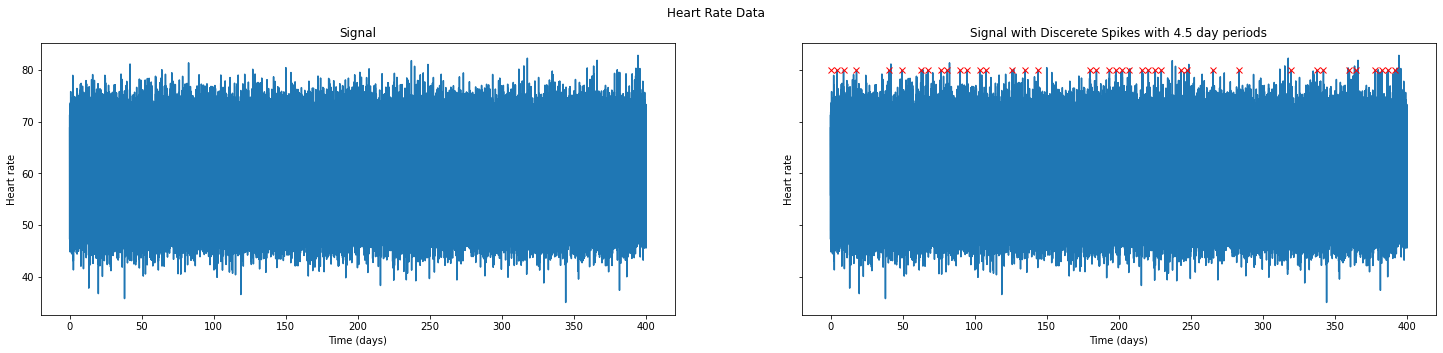

In [33]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey=True, figsize=(25,5))

axs[0].plot(time, data)
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Heart rate')
axs[0].set_title('Signal')

axs[1].plot(time, data_spikes)
axs[1].plot(time[spike_index], np.ones(len(time[spike_index]))*spike_mag, 'rx')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Heart rate')
axs[1].set_title(f'Signal with Discerete Spikes with {spike_period/minsday} day periods')

plt.suptitle('Heart Rate Data')

Text(0.5, 1.0, 'Moving Average with Spikes @ 1.0 days')

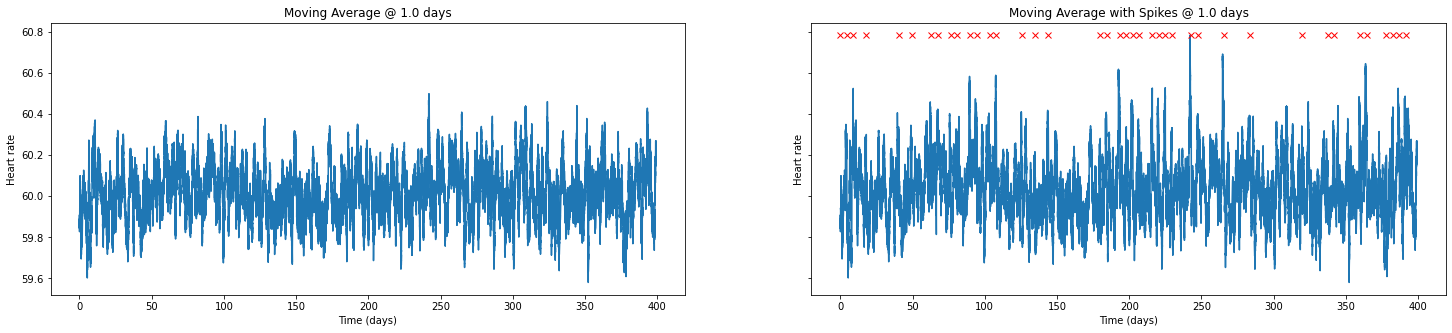

In [34]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(25,5))

axs[0].plot(time[:-(window-1)], data_MA)
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Heart rate')
axs[0].set_title(f'Moving Average @ {window/minsday} days')

axs[1].plot(time[:-(window-1)], data_MA_spikes)
axs[1].plot(time[spike_index], np.ones(len(time[spike_index]))*data_MA_spikes.max(), 'rx')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Heart rate')
axs[1].set_title(f'Moving Average with Spikes @ {window/minsday} days')

Text(0.5, 1.0, 'Average Non-Overlapping Windows with Spikes @ 1.0 days')

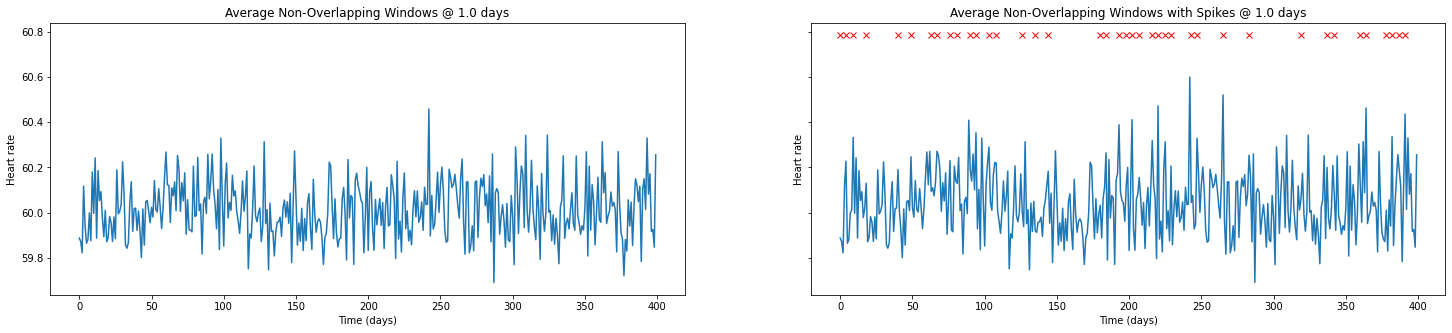

In [35]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(25,5))

axs[0].plot(time_non_overlapping, data_MA_non_overlapping)
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Heart rate')
axs[0].set_title(f'Average Non-Overlapping Windows @ {window/minsday} days')

axs[1].plot(time_non_overlapping, data_spikes_MA_non_overlapping)
axs[1].plot(time_non_overlapping[spike_index//window], np.ones(len(time_non_overlapping[spike_index//window]))*data_MA_spikes.max(), 'rx')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Heart rate')
axs[1].set_title(f'Average Non-Overlapping Windows with Spikes @ {window/minsday} days')

Spike frequency should be at 0.2222222222222222


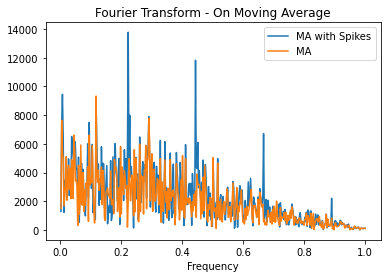

In [36]:
# The best graph to use would be the Fourier transform of each on one

# plot fourier transform for comparison
yf1 = rfft(data_MA, norm=normalisation)
yf2 = rfft(data_MA_spikes, norm=normalisation)
xf = rfftfreq(len(data_MA), sampling_period)
# plt.semilogx(xf[1:], np.abs(yf[1:]))
plt.plot(xf[1:duration//minsday], np.abs(yf2[1:duration//minsday]), label='MA with Spikes')
plt.plot(xf[1:duration//minsday], np.abs(yf1[1:duration//minsday]), label='MA') # Focus only on the low frequency material
plt.xlabel('Frequency')
plt.legend()
plt.title("Fourier Transform - On Moving Average")
print(f'Spike frequency should be at {1/spike_period*minsday}')

Spike frequency should be at 0.2222222222222222


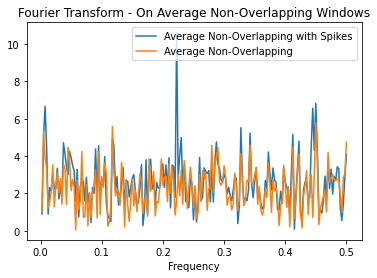

In [44]:
# The best graph to use would be the Fourier transform of each on one

# plot fourier transform for comparison
yf1 = rfft(data_MA_non_overlapping, norm=normalisation)
yf2 = rfft(data_spikes_MA_non_overlapping, norm=normalisation)
xf = rfftfreq(len(data_MA_non_overlapping), sampling_period*window)
# plt.semilogx(xf[1:], np.abs(yf[1:]))
plt.plot(xf[1:duration//minsday], np.abs(yf2[1:duration//minsday]), label='Average Non-Overlapping with Spikes')
plt.plot(xf[1:duration//minsday], np.abs(yf1[1:duration//minsday]), label='Average Non-Overlapping') # Focus only on the low frequency material
plt.xlabel('Frequency')
plt.legend()
plt.title("Fourier Transform - On Average Non-Overlapping Windows")
print(f'Spike frequency should be at {1/spike_period*minsday}')

Spike frequency should be at 0.2222222222222222


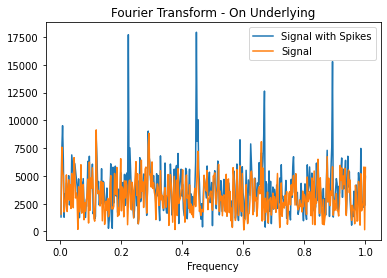

In [38]:
# The best graph to use would be the Fourier transform of each on one

# plot fourier transform for comparison
yf1 = rfft(data, norm=normalisation)
yf2 = rfft(data_spikes, norm=normalisation)
xf = rfftfreq(len(data_MA), sampling_period)
# plt.semilogx(xf[1:], np.abs(yf[1:]))
plt.plot(xf[1:duration//minsday], np.abs(yf2[1:duration//minsday]), label='Signal with Spikes')
plt.plot(xf[1:duration//minsday], np.abs(yf1[1:duration//minsday]), label='Signal') # Focus only on the low frequency material
plt.xlabel('Frequency')
plt.legend()
plt.title("Fourier Transform - On Underlying")
print(f'Spike frequency should be at {1/spike_period*minsday}')

## Overall comments:
* Distinct spikes are present in the Fourier Transform corresponding to the spike period (and resonant frequencies) of the discrete spike (seizure or otherwise) event (by comparing the signal with the signal with spikes).
* This suggests that under realistically possible situations, discrete (seizure or otherwise) events can produce a cyclical pattern in the data irrespective of the underlying data's original periodicity.  
    *  This occurs even with averaged data.
* As seen in literature, a stochastic process can produce something similar to a cyclical pattern.  This can easily be used to infer the likelihood of a seizure event.

In [ ]:
# Just to stop notebook running - Wavelet transform version below (not updated)
1/0

ZeroDivisionError: division by zero

Text(0.5, 0.98, 'No Spike MA Signal')

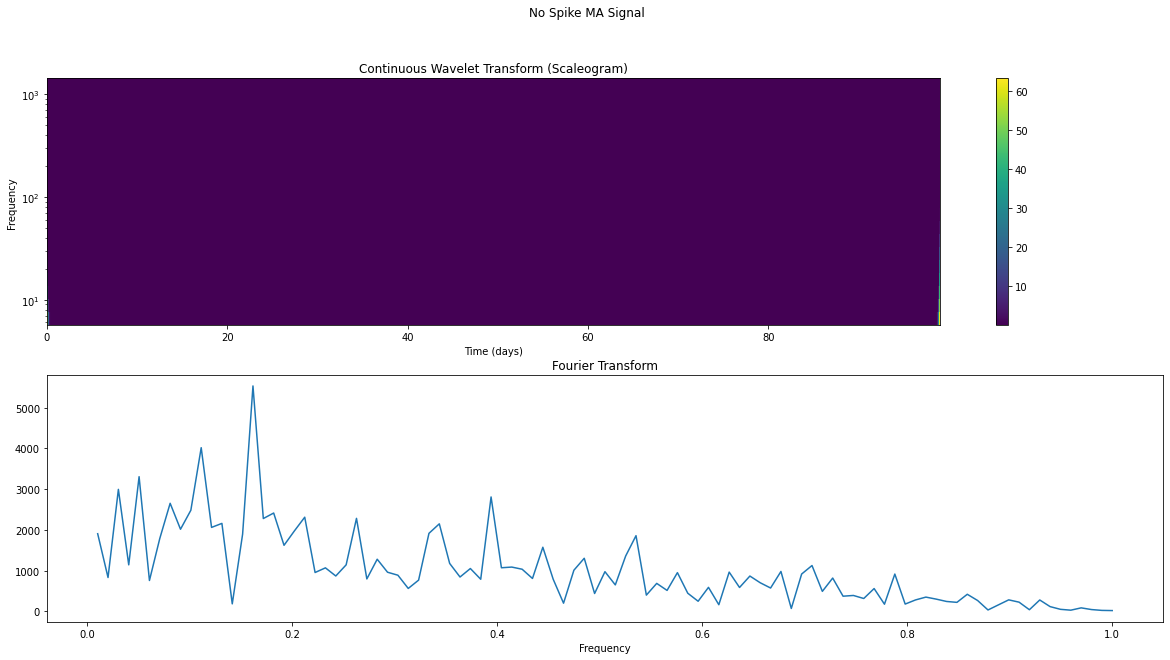

In [ ]:
# Define the wavelet transform
wavelet = "cmor1.5-1.0"
# widths = np.arange(1,50)
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 256, num=20)
# Sampling period
sampling_period = np.diff(time).mean()

# Apply the wavelet transform
coeffs, freqs = pywt.cwt(data_MA, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(coeffs[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1, figsize=(20,10))
pcm = axs[0].pcolormesh(time[:-(window-1)], freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (days)")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
yf = rfft(data_MA)
xf = rfftfreq(len(data_MA), sampling_period)
# plt.semilogx(xf[1:], np.abs(yf[1:]))
plt.plot(xf[1:100], np.abs(yf[1:100])) # Focus only on the low frequency material
axs[1].set_xlabel("Frequency")
axs[1].set_title("Fourier Transform")
plt.suptitle('No Spike MA Signal')

Text(0.5, 0.98, 'No Spike Signal')

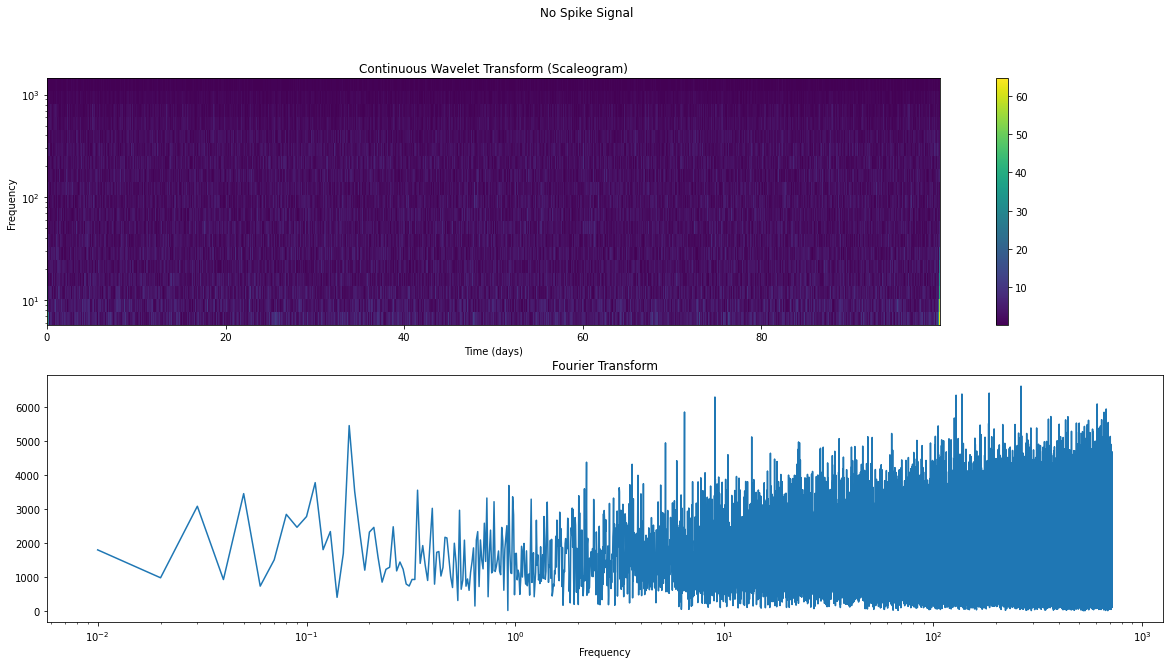

In [ ]:
# Define the wavelet transform
wavelet = "cmor1.5-1.0"
# widths = np.arange(1,50)
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 256, num=20)
# Sampling period
sampling_period = np.diff(time).mean()

# Apply the wavelet transform
coeffs, freqs = pywt.cwt(data, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(coeffs[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1, figsize=(20,10))
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (days)")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
yf = rfft(data)
xf = rfftfreq(len(data), sampling_period)
plt.semilogx(xf[1:], np.abs(yf[1:]))
axs[1].set_xlabel("Frequency")
axs[1].set_title("Fourier Transform")
plt.suptitle('No Spike Signal')

Text(0.5, 0.98, 'Spike MA Signal')

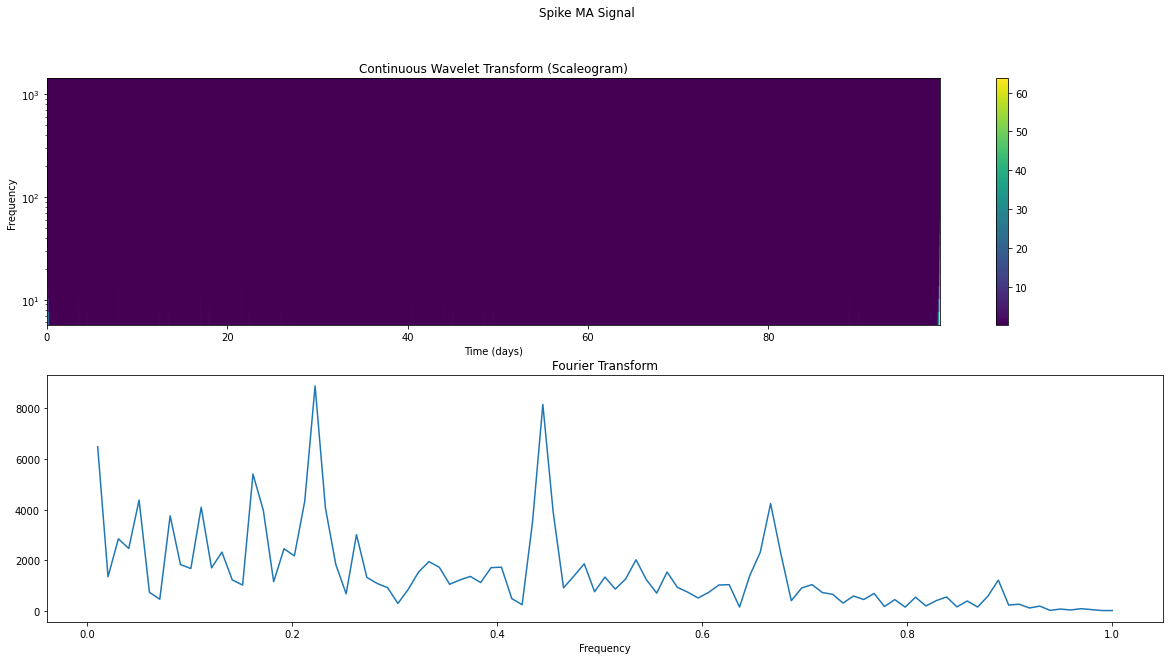

In [ ]:
# Define the wavelet transform
wavelet = "cmor1.5-1.0"
# widths = np.arange(1,50)
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 256, num=20)
# Sampling period
sampling_period = np.diff(time).mean()

# Apply the wavelet transform
coeffs, freqs = pywt.cwt(data_MA_spikes, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(coeffs[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1, figsize=(20,10))
pcm = axs[0].pcolormesh(time[:-(window-1)], freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (days)")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
yf = rfft(data_MA_spikes)
xf = rfftfreq(len(data_MA_spikes), sampling_period)
# plt.semilogx(xf[1:], np.abs(yf[1:]))
plt.plot(xf[1:100], np.abs(yf[1:100])) # Focus only on the low frequency material
axs[1].set_xlabel("Frequency")
axs[1].set_title("Fourier Transform")
plt.suptitle('Spike MA Signal')

Text(0.5, 0.98, 'Spike Signal')

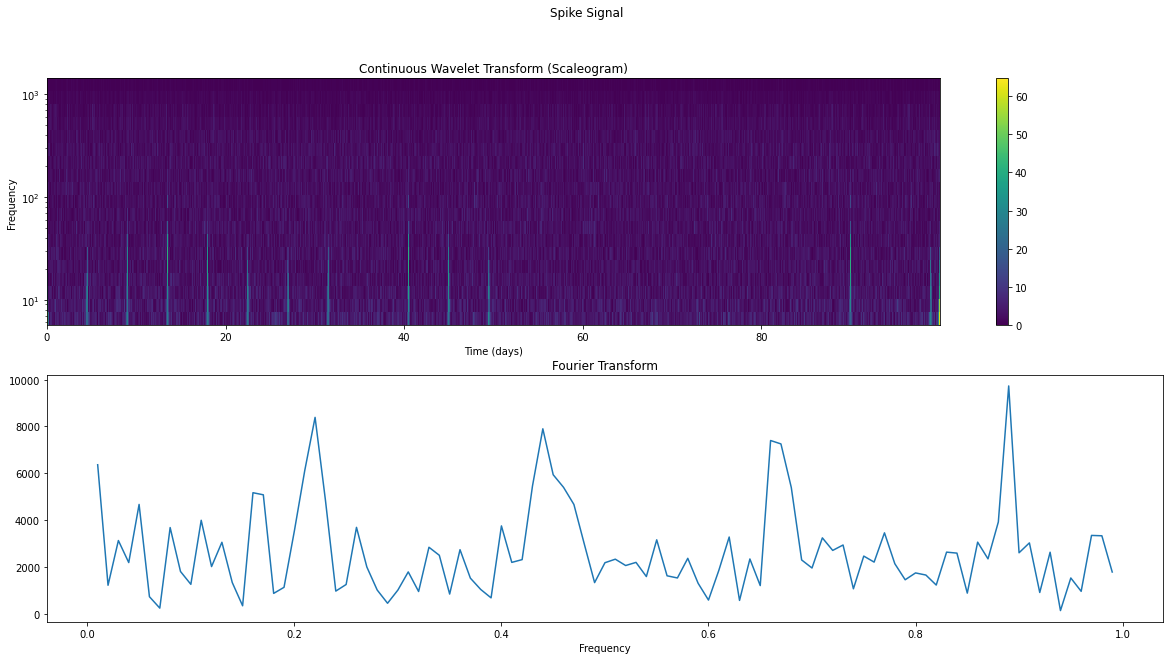

In [ ]:
# Define the wavelet transform
wavelet = "cmor1.5-1.0"
# widths = np.arange(1,50)
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 256, num=20)
# Sampling period
sampling_period = np.diff(time).mean()

# Apply the wavelet transform
coeffs, freqs = pywt.cwt(data_spikes, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(coeffs[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1, figsize=(20,10))
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (days)")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
yf = rfft(data_spikes)
xf = rfftfreq(len(data_spikes), sampling_period)
# plt.semilogx(xf[1:], np.abs(yf[1:])) # or just use plot - [1:] to drop the constant shift power.
plt.plot(xf[1:100], np.abs(yf[1:100])) # Focus only on the low frequency material
axs[1].set_xlabel("Frequency")
axs[1].set_title("Fourier Transform")
plt.suptitle('Spike Signal')